<a href="https://colab.research.google.com/github/nickwan/qb_pressures/blob/master/qb_pressures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QB Pressures

#Load in 


In [1]:
!apt install subversion --quiet
!pip install adjustText --quiet
!pip install shap --quiet
!pip install scikit-garden --quiet
!pip install rpy2 --quiet 

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 33 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd6

In [2]:
import time
from joblib import dump, load
import random
import requests
import json
import datetime
import os
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from adjustText import adjust_text
from tqdm.notebook import tqdm

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import KFold 

from scipy.stats import pearsonr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
# # # probably shouldn't rerun the full thing since it takes +30 mins 
# st = time.time()
# !svn export https://github.com/guga31bb/nflfastR-data/trunk/data "/content/drive/My Drive/nflfastR-data/data" --force --quiet
# !svn export https://github.com/guga31bb/nflfastR-data/trunk/roster-data "/content/drive/My Drive/nflfastR-data/roster-data" --force --quiet
# dur = time.time() - st 
# print(f"1 iteration dur (s): {dur}\nETA (min): {6*round(dur/60)}")


In [4]:
# For parquet file load 
data_dir = '/content/drive/My Drive/nflfastR-data'
data_files = [f'{data_dir}/data/{x}' for x in os.listdir(f"""{data_dir}/data""") if x.endswith('.parquet')]
# data_files = [x for x in data_files if int(x[-8:-4]) >= 2009]
df = pd.DataFrame()
for fn in tqdm(reversed(data_files)):
  _df = pd.read_parquet(fn)
  df= df.append(_df,ignore_index=True)
df['ones'] = 1  
df.shape  

(996549, 323)

In [5]:
roster = pd.read_csv(f"{data_dir}/roster-data/roster.csv")
roster.shape

(56175, 28)

# Data exploration 

In [7]:
df.loc[df['pass']==1,['qb_dropback', 'qb_kneel', 'qb_spike',
       'qb_scramble','sack','epa','success','pass','penalty']].describe()

,qb_dropback,qb_kneel,qb_spike,qb_scramble,sack,epa,success,pass,penalty
count,436075.000000,436773.000000,436773.000000,436773.000000,436075.000000,434812.000000,434812.000000,436773.0,436075.000000
mean,0.946622,0.000002,0.000114,0.030146,0.059068,0.043687,0.455926,1.0,0.063448
std,0.224787,0.001513,0.010699,0.170989,0.235752,1.576672,0.498054,0.0,0.243767
min,0.000000,0.000000,0.000000,0.000000,0.000000,-12.887873,0.000000,1.0,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,-0.720068,0.000000,1.0,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,-0.188067,0.000000,1.0,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.935285,1.000000,1.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,9.427382,1.000000,1.0,1.000000


In [8]:
df.loc[df['qb_hit']==1,['qb_dropback', 'qb_kneel', 'qb_spike',
       'qb_scramble','sack','epa','success','pass','penalty']].describe()

,qb_dropback,qb_kneel,qb_spike,qb_scramble,sack,epa,success,pass,penalty
count,42166.000000,42166.0,42166.0,42166.000000,42166.000000,42002.000000,42002.000000,42166.000000,42166.000000
mean,0.991937,0.0,0.0,0.000213,0.513281,-0.888665,0.155564,0.999763,0.026704
std,0.089435,0.0,0.0,0.014608,0.499830,1.492000,0.362446,0.015398,0.161219
min,0.000000,0.0,0.0,0.000000,0.000000,-12.126753,0.000000,0.000000,0.000000
25%,1.000000,0.0,0.0,0.000000,0.000000,-1.566902,0.000000,1.000000,0.000000
50%,1.000000,0.0,0.0,0.000000,1.000000,-1.023506,0.000000,1.000000,0.000000
75%,1.000000,0.0,0.0,0.000000,1.000000,-0.465126,0.000000,1.000000,0.000000
max,1.000000,0.0,0.0,1.000000,1.000000,8.155553,1.000000,1.000000,1.000000


In [9]:
hits = df.loc[(df['season']>=2006)&(df['qb_hit']==1)&(df['penalty']==0)].copy()
hits.shape

(34946, 323)

In [10]:
plays_sum = df.loc[:,['season','posteam','ones']].groupby(['season','posteam'],as_index=False).sum()
hits_sum = hits.loc[:,['season','posteam','pass','epa','sack','ones']].groupby(['season','posteam'],as_index=False).sum()
hits_sum = hits_sum.merge(plays_sum.rename(columns={'ones':'total_plays'}))
hits_sum['hits_per_play'] = hits_sum['ones'].div(hits_sum['total_plays'])

In [11]:
hits_sum.sort_values('hits_per_play',ascending=False).head(10)

,season,posteam,pass,epa,sack,ones,total_plays,hits_per_play
435,2019,MIA,144.0,-95.445272,56.0,144,1334,0.107946
327,2016,CLE,127.0,-85.284393,58.0,127,1285,0.098833
285,2014,TB,121.0,-95.590278,46.0,121,1242,0.097424
359,2017,CLE,122.0,-106.130815,46.0,122,1304,0.093558
417,2019,ATL,132.0,-96.173008,49.0,132,1419,0.093023
396,2018,HOU,131.0,-126.351211,63.0,131,1433,0.091417
333,2016,IND,124.0,-75.471080,42.0,124,1360,0.091176
270,2014,JAX,116.0,-129.404161,67.0,116,1298,0.089368
412,2018,SF,117.0,-82.673146,44.0,117,1314,0.089041
403,2018,MIA,105.0,-97.981621,52.0,105,1181,0.088908


In [12]:
hits_sum.sort_values('ones',ascending=False).tail(10)

,season,posteam,pass,epa,sack,ones,total_plays,hits_per_play
158,2010,TEN,41.0,-42.844159,21.0,41,1269,0.032309
36,2007,CAR,41.0,-49.707616,27.0,41,1331,0.030804
338,2016,LV,41.0,-37.375262,19.0,41,1494,0.027443
126,2009,TEN,40.0,-39.881089,12.0,40,1317,0.030372
94,2008,TEN,39.0,-28.748698,8.0,39,1390,0.028058
39,2007,CLE,39.0,-32.216188,17.0,39,1365,0.028571
65,2008,ATL,38.0,-31.164159,17.0,38,1432,0.026536
54,2007,NO,36.0,-30.132779,7.0,36,1407,0.025586
68,2008,CAR,35.0,-26.062936,17.0,35,1361,0.025716
73,2008,DEN,18.0,-13.773149,11.0,18,1340,0.013433


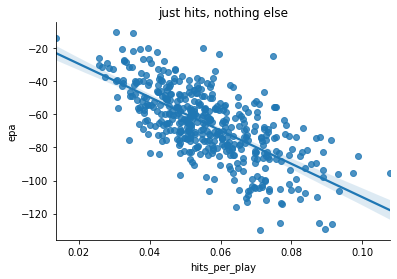

In [13]:
sns.regplot(x='hits_per_play',y='epa',data=hits_sum)
sns.despine()
plt.title('just hits, nothing else')
plt.show()

In [14]:
hits_pos = df.loc[df['pass']==1,['season','posteam','epa']].groupby(['season','posteam'],as_index=False).sum().merge(hits_sum.loc[:,['season','posteam','hits_per_play']])

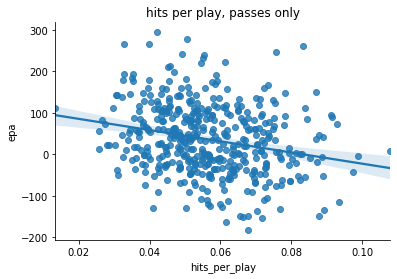

In [15]:
sns.regplot(x='hits_per_play',y='epa',data=hits_pos)
sns.despine()
plt.title('hits per play, passes only')
plt.show()

In [16]:
df.loc[df['pass']==1,['season','posteam','defteam','epa']].groupby(['season','posteam','defteam'],as_index=False).sum()

,season,posteam,defteam,epa
0,1999,ARI,ATL,-8.013808
1,1999,ARI,BUF,-1.418533
2,1999,ARI,DAL,-18.215727
3,1999,ARI,DET,0.411669
4,1999,ARI,GB,6.101999
...,...,...,...,...
8779,2019,WAS,NE,-24.504900
8780,2019,WAS,NYG,0.569430
8781,2019,WAS,NYJ,-13.043349
8782,2019,WAS,PHI,22.623459


In [17]:
plays_sum = df.loc[:,['season','defteam','ones']].groupby(['season','defteam'],as_index=False).sum()
hits_sum = hits.loc[:,['season','defteam','pass','epa','sack','ones']].groupby(['season','defteam'],as_index=False).sum()
hits_sum = hits_sum.merge(plays_sum.rename(columns={'ones':'total_plays'}))
hits_sum['hits_per_play'] = hits_sum['ones'].div(hits_sum['total_plays'])
hits_def = df.loc[df['pass']==1,['season','defteam','epa']].groupby(['season','defteam'],as_index=False).sum().merge(hits_sum.loc[:,['season','defteam','hits_per_play']])

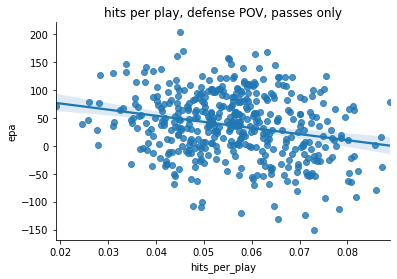

In [18]:
sns.regplot(x='hits_per_play',y='epa',data=hits_def)
sns.despine()
plt.title('hits per play, defense POV, passes only')
plt.show()

In [19]:
hits_def.sort_values('hits_per_play',ascending=False).head(10)

,season,defteam,epa,hits_per_play
409,2018,PHI,78.699354,0.088980
377,2017,PHI,-37.390073,0.087240
266,2014,DET,15.555503,0.087052
297,2015,DEN,-78.961203,0.085871
340,2016,MIN,1.669949,0.085870
442,2019,PIT,-44.599828,0.082202
292,2015,CAR,-92.358628,0.081710
312,2015,NYJ,-18.047068,0.081369
410,2018,PIT,64.700220,0.081307
258,2014,BAL,71.134661,0.081205


In [20]:
hits_def.sort_values('hits_per_play',ascending=False).tail(10)

,season,defteam,epa,hits_per_play
36,2007,CAR,36.324696,0.031025
31,2006,WAS,130.523486,0.030928
73,2008,DEN,126.259984,0.028223
41,2007,DEN,76.280854,0.028116
50,2007,LV,0.822578,0.027799
111,2009,KC,27.801211,0.027679
81,2008,LAC,78.916401,0.025933
82,2008,LV,46.715598,0.025788
33,2007,ATL,39.515533,0.024566
79,2008,KC,71.487209,0.018992


In [21]:
model_data = (df
              .loc[(df['pass']==1)&
                   (df['penalty']==0)&
                   (df['season']>=2006),
                   ['game_id','season','posteam',
                    'defteam','epa','qb_hit','ones']]
              .groupby(['game_id','season','posteam','defteam'],
                       as_index=False)
              .sum())
model_data.shape

(7476, 7)

In [22]:
model_data['game_hits_per_play'] = model_data['qb_hit'].div(model_data['ones'])

In [23]:
model_data = (model_data
              .merge(hits_pos
                     .loc[:,['season','posteam','hits_per_play']]
                     .rename(columns={'hits_per_play':'pos_hits_per_play'}))
              .merge(hits_def
                     .loc[:,['season','defteam','hits_per_play']]
                     .rename(columns={'hits_per_play':'def_hits_per_play'})))

In [24]:
model_feats = ['pos_hits_per_play', 'def_hits_per_play']
target = 'game_hits_per_play'

In [ ]:
df_pred = pd.DataFrame()
kf = KFold(10,shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

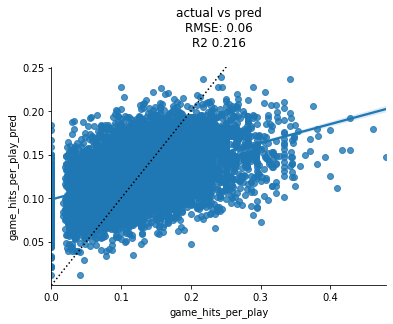

In [26]:
rmse = mean_squared_error(df_pred[target],df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target],df_pred[f"{target}_pred"])[0]**2

f = sns.regplot(target,f"{target}_pred",data=df_pred)
xlim = f.get_xlim()
ylim = f.get_ylim()
plt.plot([0,1],[0,1],"k:")
f.set_xlim(xlim)
f.set_ylim(ylim)
plt.title(f"""actual vs pred\nRMSE: {round(rmse,3)}\nR2 {round(r2,3)}\n""")
sns.despine()
plt.show()

In [ ]:
model_feats = ['pos_hits_per_play', 'def_hits_per_play']
target = 'epa'

df_pred = pd.DataFrame()
kf = KFold(10,shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = LinearRegression()
  model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  test_data[f"{target}_pred"] = pd.Series(model.predict(test_data.loc[:,model_feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)

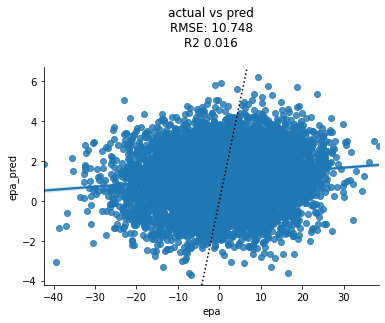

In [28]:
rmse = mean_squared_error(df_pred[target],df_pred[f"{target}_pred"])**0.5
r2 = pearsonr(df_pred[target],df_pred[f"{target}_pred"])[0]**2

f = sns.regplot(target,f"{target}_pred",data=df_pred)
xlim = f.get_xlim()
ylim = f.get_ylim()
plt.plot([-100,100],[-100,100],"k:")
f.set_xlim(xlim)
f.set_ylim(ylim)
plt.title(f"""actual vs pred\nRMSE: {round(rmse,3)}\nR2 {round(r2,3)}\n""")
sns.despine()
plt.show()

These models aren't horrible. They are a great starting point for trying to parse out the contributions of the defense on qb pressures and the "contributions" of the offense on qb pressures. To some extent we can predict how many hits per game a QB may incur using season hits-per-play aggregates for the offense and defense. This did not accurately predict EPA for a game. 

Some things to try: control for more things on offense given the QB -- control for more things on the defense given perhaps top performers in the season?  


# Isolate more shit  

In [31]:
df_hits = df.loc[(df['season']>=2006)&(df['qb_hit']==1)&(df['penalty']==0)&(df['pass']==1)]
df_hits.shape

(34936, 323)

In [46]:
qb_hit_success = df_hits.loc[:,['season','passer','success','epa','ones']].groupby(['season','passer'],as_index=False).sum()
qb_hit_success = qb_hit_success.rename(columns={'ones':'n_hits'})
qb_hit_success.shape

(1000, 5)

In [47]:
qb_hit_success['success_per_hit'] = qb_hit_success['success'].div(qb_hit_success['n_hits'])
qb_hit_success['epa_per_hit'] = qb_hit_success['epa'].div(qb_hit_success['n_hits'])

count    501.000000
mean     609.638723
std       94.038818
min      426.000000
25%      540.000000
50%      611.000000
75%      672.000000
max      875.000000
Name: ones, dtype: float64

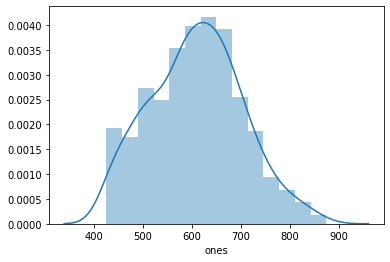

In [54]:
qb_threshold = df.loc[:,['season','passer','ones']].groupby(['season','passer'],as_index=False).sum()
sns.distplot(qb_threshold.loc[qb_threshold['ones']>425,'ones'])
qb_threshold.loc[qb_threshold['ones']>425,'ones'].describe()

In [57]:
qb_hit_success = qb_hit_success.merge(qb_threshold.loc[qb_threshold['ones']>425,['season','passer']])

0.16611114303775645

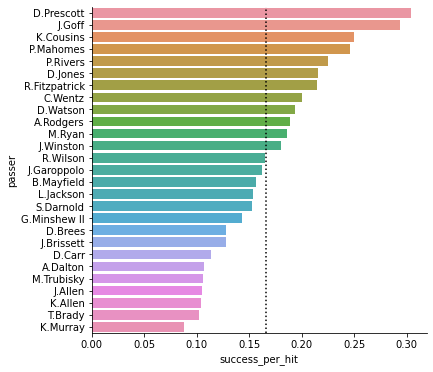

In [73]:
y = 'success_per_hit'
df_plt = (qb_hit_success
          .loc[qb_hit_success['season']==2019]
          .sort_values('epa',ascending=False)
          .reset_index(drop=True))
order = df_plt.sort_values(y,ascending=False)['passer'].values
sns.barplot(y,'passer',data=df_plt, orient='h', order=order)
sns.despine()
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0],6)
plt.axvline(df_hits['success'].mean(),c='k',ls=':')
plt.show()

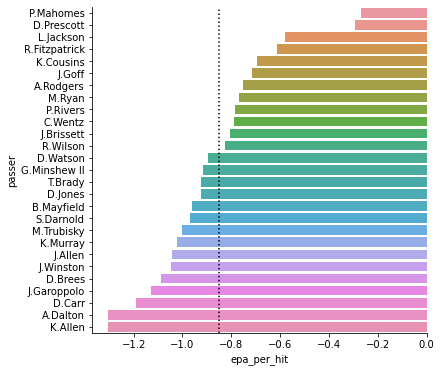

In [76]:
y = 'epa_per_hit'
df_plt = (qb_hit_success
          .loc[qb_hit_success['season']==2019]
          .sort_values('epa',ascending=False)
          .reset_index(drop=True))
order = df_plt.sort_values(y,ascending=False)['passer'].values
sns.barplot(y,'passer',data=df_plt, orient='h', order=order)
sns.despine()
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0],6)
plt.axvline(df_hits['epa'].mean(),c='k',ls=':')
plt.show()